In [1]:
import io
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

/home/asemenov/study/otus/MLProfessional/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asemenov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
elon_df = pd.concat([
    pd.read_csv('data/elon/2019.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2020.csv', index_col=0).set_index('id', drop=True),
    pd.read_csv('data/elon/2021.csv', index_col='id'),
])[['tweet', 'date']]
elon_df.rename(columns={'tweet': 'text'}, inplace=True)
elon_df['datetime'] = pd.to_datetime(elon_df['date'])
elon_df['date'] = pd.to_datetime(elon_df['datetime'].dt.date)
elon_df = elon_df.query("date >= '2019-01-01' and date < '2022-01-01'")
elon_df.drop_duplicates(inplace=True)
elon_df.head()

,text,date,datetime
id,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,2019-12-28 23:47:59
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,2019-12-28 23:38:57
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,2019-12-28 23:22:36
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,2019-12-28 22:42:53
1211051740562366464,@geofficient Pretty much,2019-12-28,2019-12-28 22:30:09


In [4]:
def text_preprocessor(v: str) -> str:
    v = v.lower()
    v = re.sub(r'@[^\s]+', '', v)
    v = re.sub(r'https?://[^\s]+', '', v)
    v = re.sub(r'&\w+;', '', v)
    v = re.sub('\W+', ' ', v)
    v = v.strip()
    return v

In [5]:
empty_tweets = (
    elon_df.text
    .apply(text_preprocessor)
    .apply(lambda v: ' '.join(word for word in v.split() if word not in stop_words))
    .apply(lambda v: not not re.fullmatch('\W*', v))
)
print(elon_df[empty_tweets].shape)
elon_df[empty_tweets]

(732, 3)


,text,date,datetime
id,,,
1210263196457504768,@teslaownersSV @tesla_unplugged @TeslaOwnersof...,2019-12-26,2019-12-26 18:16:46
1209141597629243393,@markets 🤣🤣,2019-12-23,2019-12-23 15:59:56
1205682780178280448,https://t.co/LxZAmZIcIS,2019-12-14,2019-12-14 02:55:49
1205680930779590657,https://t.co/aAEFph9G6D,2019-12-14,2019-12-14 02:48:29
1205050955927932928,@SamTalksTesla https://t.co/z6zljrfUmb,2019-12-12,2019-12-12 09:05:11
...,...,...,...
1348017194349694978,@BoredElonMusk 🤣🤣,2021-01-10,2021-01-10 00:00:00
1348007662491820033,@erigganewmoney 😢,2021-01-10,2021-01-10 00:00:00
1347976356135518211,@Christo49699922 @sean18743005 @Erdayastronaut...,2021-01-09,2021-01-09 00:00:00


In [6]:
elon_df = elon_df[~empty_tweets]
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8645 entries, 1211071324518531072 to 1344810193952014336
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   text      8645 non-null   object        
 1   date      8645 non-null   datetime64[ns]
 2   datetime  8645 non-null   datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 270.2+ KB


In [7]:
tweet_words = set()
elon_df.text.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v not in set(stop_words)]).apply(tweet_words.update)
len(tweet_words)

9651

In [8]:
def load_vectors(fname, words: set):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin, total=n):
        tokens = line.rstrip().split(' ')
        word = tokens[0].lower()
        if word in words:
            data[word] = np.array([*map(float, tokens[1:])])
    return data

In [9]:
word_embeddings = load_vectors('wiki-news-300d-1M.vec', tweet_words)

100%|█████████████████████████████████████████████████████████| 999994/999994 [00:15<00:00, 65479.80it/s]


In [10]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    # ngram_range=(1, 2),
    # max_features=1000,
    preprocessor=text_preprocessor
)
tfidf_vectorizer.fit(elon_df.text)
len(tfidf_vectorizer.vocabulary_)

9615

In [11]:
def tfidf_dict(text: str) -> dict:
    return {
        tfidf_vectorizer.get_feature_names_out()[i]: tfidf_v
        for (_, i), tfidf_v in (
            tfidf_vectorizer
            .transform([text])
            .todok()
            .items()
        )
    }

In [12]:
tfidf_dict('starship go to mars')

{'go': 0.6289582166972971,
 'mars': 0.5727404913062992,
 'starship': 0.5257184524697368}

In [13]:
def tweet_embedding(text: str) -> np.array:
    embedding = np.zeros(300)
    tfidf = 0
    
    text = text_preprocessor(text)
    words_tfidf = tfidf_dict(text)
    
    for word in text.split(' '):
        if word in word_embeddings and word in words_tfidf:
            word_tfidf = words_tfidf[word]
            tfidf += word_tfidf
            embedding += word_tfidf * word_embeddings[word]
    
    if tfidf:
        embedding /= tfidf
    
    return embedding

In [14]:
tweet_embedding('starship go to mars')[:10]

array([-0.00626227, -0.01661748, -0.04145496,  0.03377107, -0.05720178,
        0.02631746, -0.06718106,  0.12014136, -0.02418168,  0.05562544])

In [15]:
text_embeddings = list()


for text in tqdm(elon_df.text.values):
    text_embeddings.append(tweet_embedding(text))

text_embeddings = np.stack(text_embeddings)
text_embeddings.shape

100%|████████████████████████████████████████████████████████████████| 8645/8645 [02:47<00:00, 51.56it/s]


(8645, 300)

In [16]:
%%time
pca = PCA(n_components=2, random_state=42)
text_pca = pca.fit_transform(text_embeddings)
print('PCA done!')

umap = UMAP(n_components=2, n_jobs=-1, random_state=42)
text_umap = umap.fit_transform(text_embeddings)
print('UMAP done!')

umap_cosine = UMAP(n_components=2, n_jobs=-1, metric='cosine', random_state=42)
text_umap_cosine = umap_cosine.fit_transform(text_embeddings)
print('UMAP(cosine) done!')

PCA done!
UMAP done!
UMAP(cosine) done!
CPU times: user 59.5 s, sys: 4.87 s, total: 1min 4s
Wall time: 50.5 s


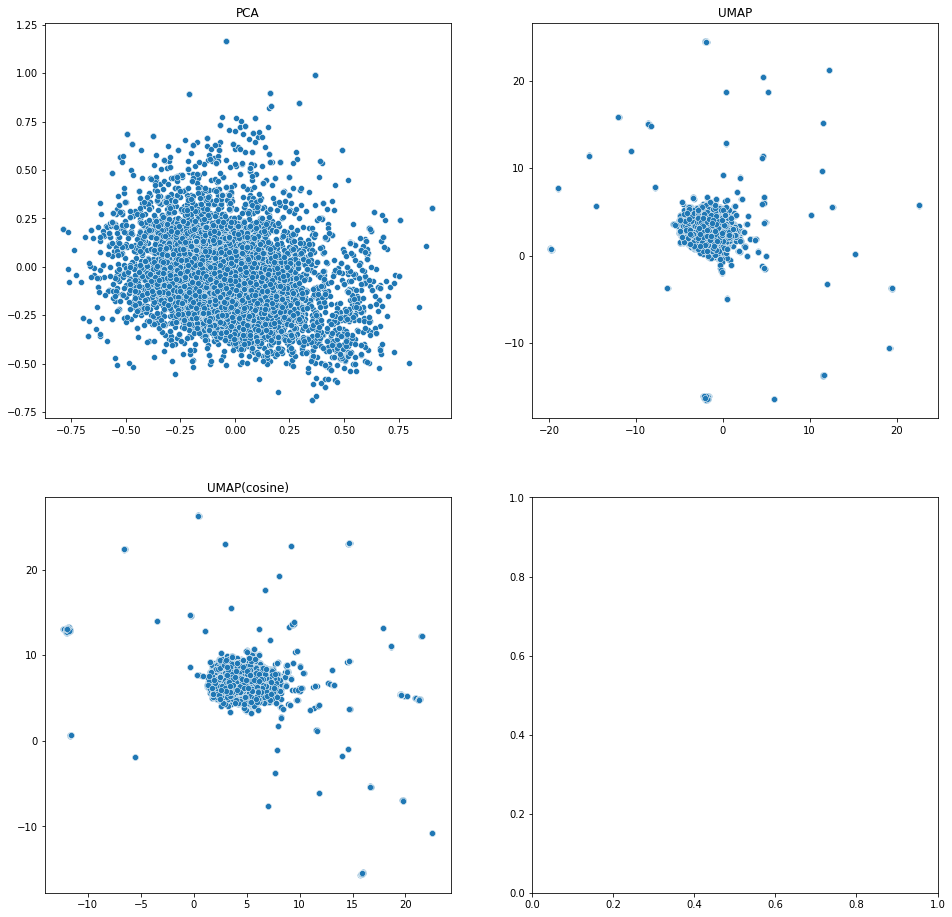

In [17]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21);

In [18]:
K = list(range(1, 16))

inertia = {}
silhouette = {}

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(text_embeddings)
    inertia[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(text_embeddings, kmeans.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████████| 15/15 [00:55<00:00,  3.73s/it]


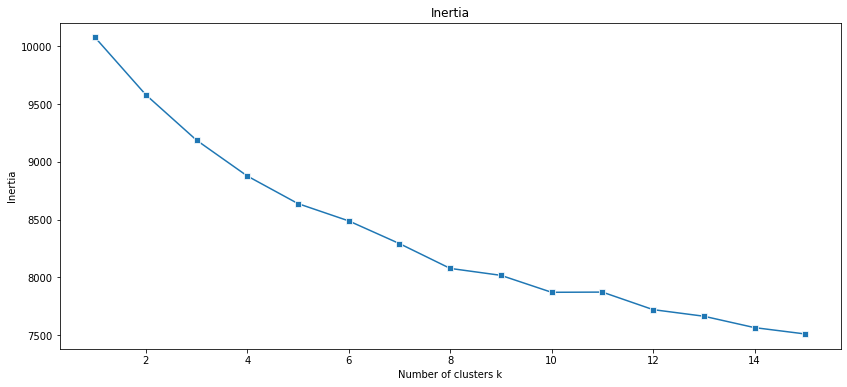

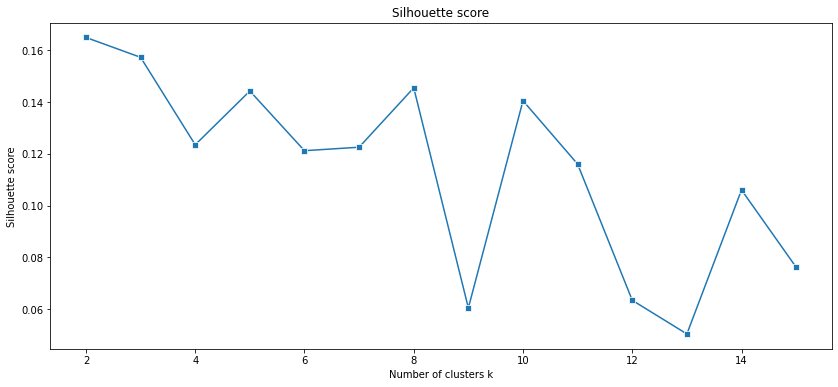

In [19]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[inertia[k] for k in K], marker='s')

plt.title('Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [20]:
d = {}
for k in K[1:-1]:
    d[k] = (inertia[k] - inertia[k + 1]) / (inertia[k - 1] - inertia[k])

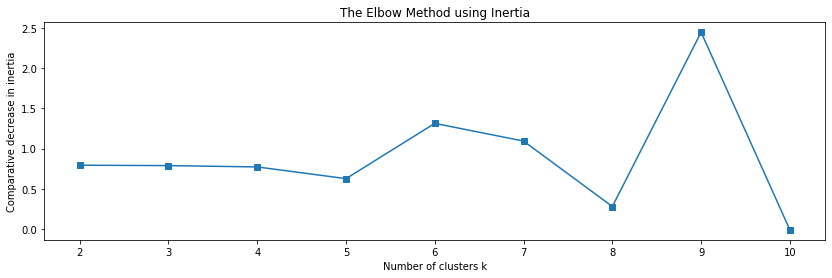

In [21]:
plt.figure(figsize=(14, 4))
plt.plot(list(d.keys())[:9], list(d.values())[:9], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

In [22]:
kmeans = KMeans(
    n_clusters=8,
    # eps=0.6,
    # metric='cosine',
    random_state=42
)
clusters = kmeans.fit_predict(text_embeddings)
# clusters = kmeans.fit_predict(text_pca)
print(len(set(clusters)))

8


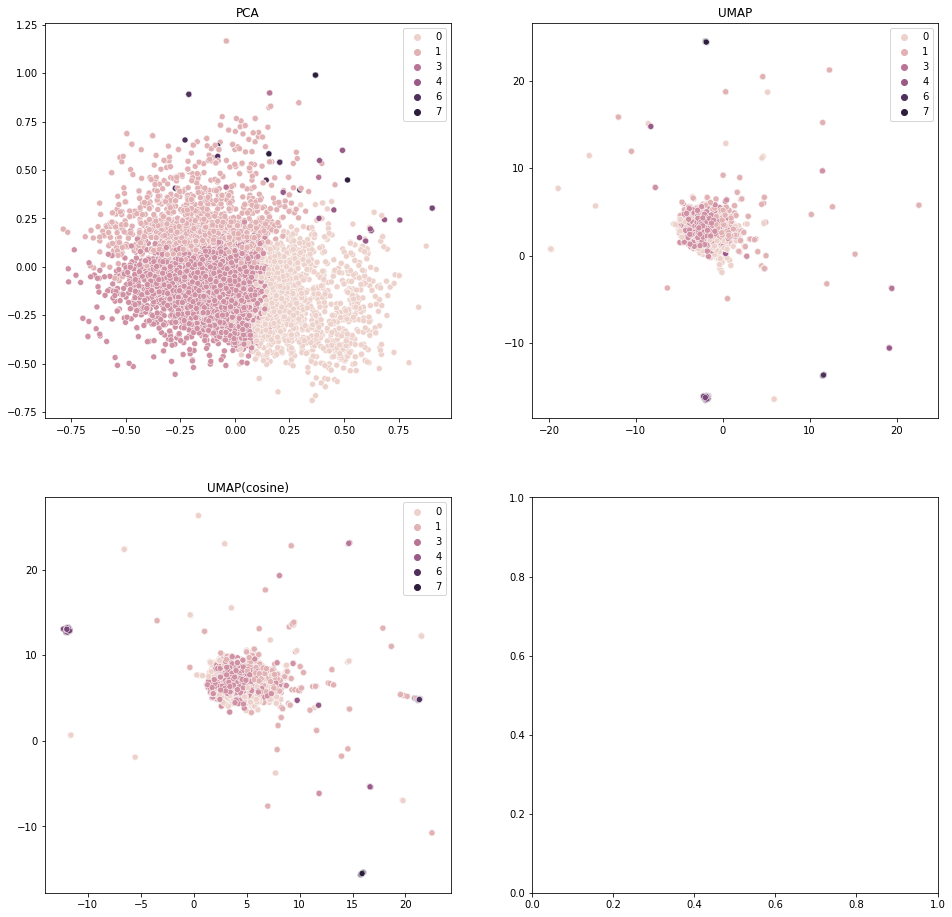

In [23]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=clusters);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=clusters);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=clusters);

In [24]:
def print_top_n_words(data: pd.Series, n: int = 25):
    words_counter = collections.Counter()
    data.apply(text_preprocessor).str.split().apply(lambda arr: [v for v in arr if v in word_embeddings]).apply(words_counter.update)
    return words_counter.most_common(n)

In [25]:
elon_df['cluster'] = clusters
elon_df.groupby('cluster')['cluster'].count()

cluster
0    1667
1    1618
2    4769
3      76
4      78
5     221
6     121
7      95
Name: cluster, dtype: int64

In [26]:
for cluster in set(elon_df['cluster']):
    print(
        f'Cluster {cluster:3}. {len(elon_df.query(f"cluster == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(elon_df.query(f'cluster == {cluster}').text, n=3)
    )

Cluster   0.  1667 tweets total. Top-3 words: [('yeah', 69), ('ok', 61), ('like', 50)]
Cluster   1.  1618 tweets total. Top-3 words: [('great', 114), ('good', 112), ('much', 91)]
Cluster   2.  4769 tweets total. Top-3 words: [('tesla', 574), ('high', 208), ('would', 207)]
Cluster   3.    76 tweets total. Top-3 words: [('sure', 76), ('hope', 4), ('ok', 1)]
Cluster   4.    78 tweets total. Top-3 words: [('haha', 76), ('yes', 3), ('awesome', 3)]
Cluster   5.   221 tweets total. Top-3 words: [('yes', 221)]
Cluster   6.   121 tweets total. Top-3 words: [('true', 118), ('haha', 24), ('truth', 3)]
Cluster   7.    95 tweets total. Top-3 words: [('exactly', 92), ('precisely', 3), ('yeah', 1)]


In [27]:
cluster = 1

print(print_top_n_words(elon_df.query(f'cluster == {cluster}').text))
elon_df.query(f'cluster == {cluster}').head(10)

[('great', 114), ('good', 112), ('much', 91), ('soon', 66), ('pretty', 54), ('coming', 53), ('like', 43), ('absolutely', 43), ('probably', 42), ('tesla', 41), ('point', 39), ('would', 38), ('haha', 38), ('sure', 37), ('make', 36), ('thanks', 34), ('way', 34), ('people', 31), ('hard', 31), ('work', 31), ('years', 30), ('long', 30), ('still', 29), ('team', 29), ('true', 27)]


,text,date,datetime,cluster
id,,,,
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,2019-12-28 23:38:57,1
1211051740562366464,@geofficient Pretty much,2019-12-28,2019-12-28 22:30:09,1
1210776160444932097,"@flcnhvy No, he’s still much faster 🐌",2019-12-28,2019-12-28 04:15:06,1
1210756338348744705,@JaneidyEve Flight is hopefully 2 to 3 months ...,2019-12-28,2019-12-28 02:56:20,1
1210270940254232577,@Erdayastronaut Most people still don’t know i...,2019-12-26,2019-12-26 18:47:32,1
1210259962598838272,@TeslaOwnersofMA @Tesla @disneyplus @BenSullin...,2019-12-26,2019-12-26 18:03:55,1
1209583623499927552,@AdamDanielKing Needs improvement,2019-12-24,2019-12-24 21:16:23,1
1208876280491327488,@therealcliffyb @Tesla Good point,2019-12-22,2019-12-22 22:25:39,1
1208863275749785600,@RationalEtienne @RenataKonkoly Don’t wanna br...,2019-12-22,2019-12-22 21:33:59,1


In [28]:
EPS = np.linspace(0.01, 10., 100)

silhouette = {}
clusters = {}

for eps in tqdm(EPS):
    dbscan = DBSCAN(eps=eps, n_jobs=-1).fit(text_embeddings) # metric='cosine' checked
    clusters[eps] = len(set(dbscan.labels_)) - 1
    # print(set(dbscan.labels_))
    if len(set(dbscan.labels_)) > 1:
        # print(eps, set(dbscan.labels_))
        silhouette[eps] = silhouette_score(text_embeddings, dbscan.labels_)
# print(silhouette

100%|██████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


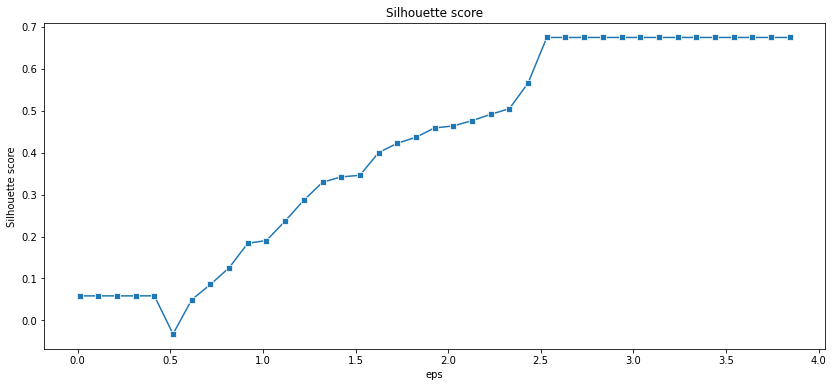

In [29]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[silhouette.get(eps) for eps in EPS], marker='s')

plt.title('Silhouette score')
plt.xlabel('eps')
plt.ylabel('Silhouette score')

plt.show()

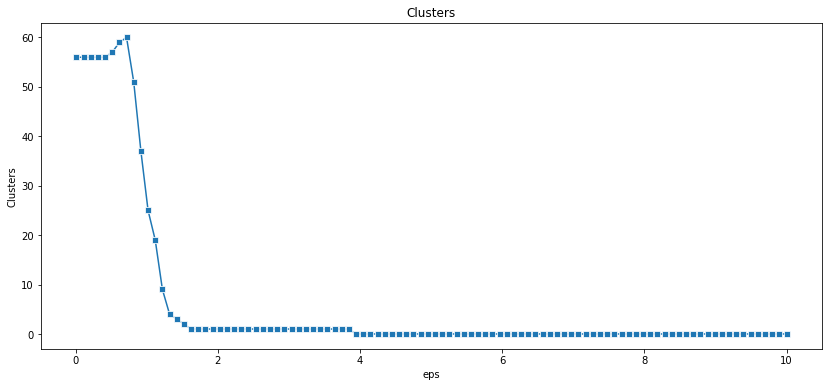

In [30]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[clusters.get(eps) for eps in EPS], marker='s')

plt.title('Clusters')
plt.xlabel('eps')
plt.ylabel('Clusters')

plt.show()

In [31]:
# best_eps = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_eps = max({eps for eps, c in clusters.items() if c == 2})
best_eps, clusters.get(best_eps)

(1.5236363636363637, 2)

In [32]:
dbscan = DBSCAN(eps=best_eps, n_jobs=-1) # metric='cosine' checked
elon_df['cluster_dbscan'] = dbscan.fit_predict(text_embeddings)

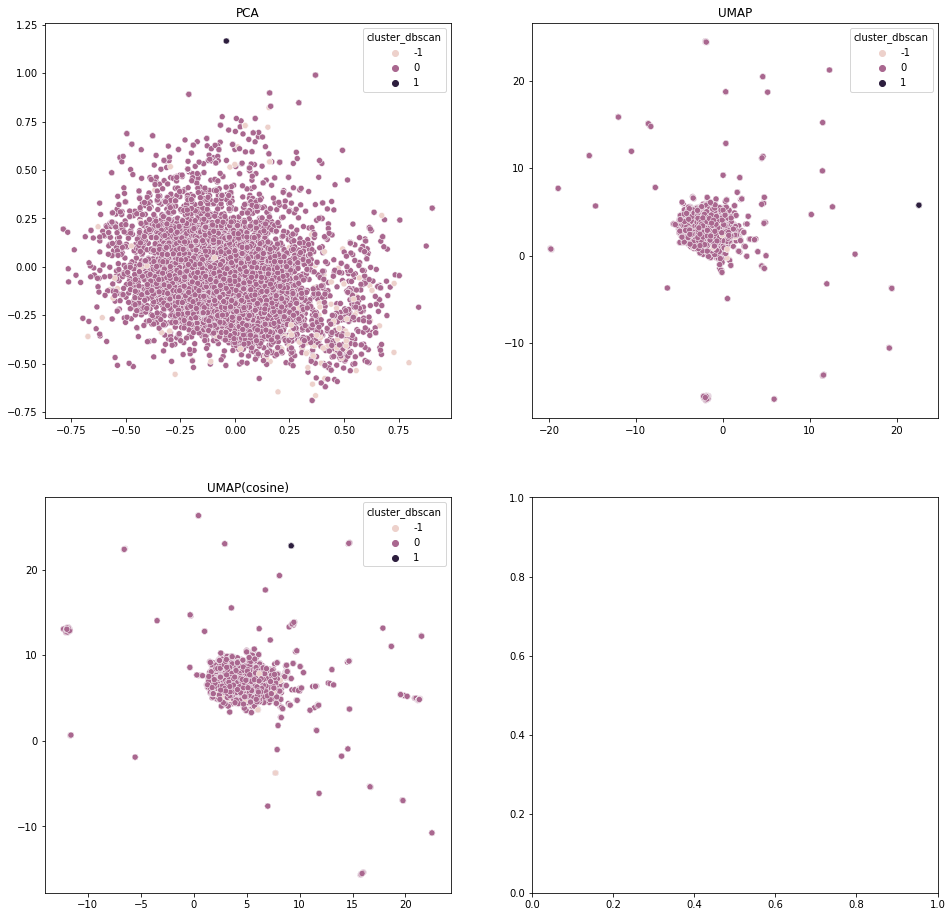

In [33]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=elon_df['cluster_dbscan']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=elon_df['cluster_dbscan']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=elon_df['cluster_dbscan']);

In [34]:
elon_df.groupby('cluster_dbscan')['cluster_dbscan'].count()

cluster_dbscan
-1     159
 0    8451
 1      35
Name: cluster_dbscan, dtype: int64

In [35]:
for cluster in set(elon_df['cluster_dbscan']):
    print(
        f'Cluster {cluster:3}. {len(elon_df.query(f"cluster_dbscan == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(elon_df.query(f'cluster_dbscan == {cluster}').text, n=3)
    )

Cluster   0.  8451 tweets total. Top-3 words: [('tesla', 661), ('yes', 385), ('great', 326)]
Cluster   1.    35 tweets total. Top-3 words: [('absolutely', 35)]
Cluster  -1.   159 tweets total. Top-3 words: [('seriously', 4), ('touché', 3), ('dance', 3)]


In [36]:
cluster = -1

print(print_top_n_words(elon_df.query(f'cluster_dbscan == {cluster}').text))
elon_df.query(f'cluster_dbscan == {cluster}').head(10)

[('seriously', 4), ('touché', 3), ('dance', 3), ('remove', 2), ('trust', 2), ('rococo', 2), ('basilisk', 2), ('horizontally', 2), ('samwise', 2), ('lame', 2), ('minor', 2), ('got', 2), ('bs', 2), ('neither', 2), ('dke', 2), ('muffin', 2), ('tunnels', 2), ('buffet', 2), ('low', 2), ('federal', 1), ('henry', 1), ('cavill', 1), ('1', 1), ('plausible', 1), ('like', 1)]


,text,date,datetime,cluster,cluster_dbscan
id,,,,,
1211030324660051968,@annerajb @justpaulinelol Federal,2019-12-28,2019-12-28 21:05:03,2,-1
1208854704374960128,@nichegamer Henry Cavill +1,2019-12-22,2019-12-22 20:59:55,0,-1
1205207220322881536,@PPathole Plausible,2019-12-12,2019-12-12 19:26:07,0,-1
1201060433156665344,Do you like our owl? https://t.co/4fNOEv3N5b,2019-12-01,2019-12-01 08:48:16,0,-1
1201002154976133126,@ZackBornstein It’s a generational thing,2019-12-01,2019-12-01 04:56:41,1,-1
1200326465104990209,@hardmaru @Tesla Touché,2019-11-29,2019-11-29 08:11:44,0,-1
1199526897887195136,250k,2019-11-27,2019-11-27 03:14:33,0,-1
1198788116372344832,200k,2019-11-25,2019-11-25 02:18:54,0,-1
1192527680119267328,Extremism is so fun! (@waitbutwhy) https://t....,2019-11-07,2019-11-07 19:42:09,2,-1


In [37]:
K = list(range(2, 50))

silhouette = {}

for k in tqdm(K):
    aggl = AgglomerativeClustering(n_clusters=k).fit(text_embeddings)
    silhouette[k] = silhouette_score(text_embeddings, aggl.labels_) if k > 1 else None

100%|████████████████████████████████████████████████████████████████████| 48/48 [08:15<00:00, 10.31s/it]


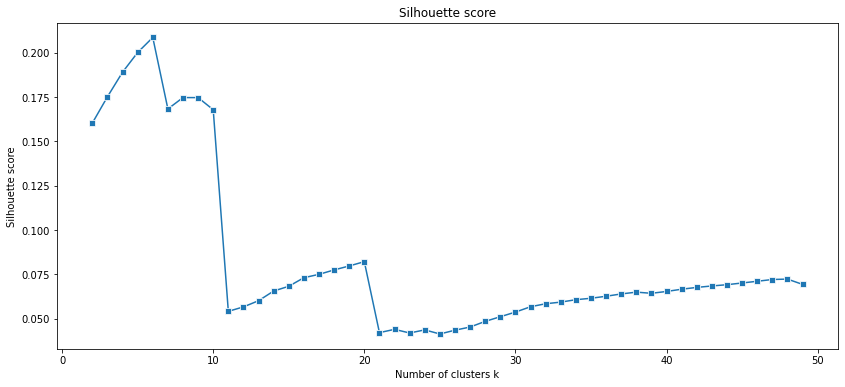

In [38]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [39]:
best_k = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_k

6

In [40]:
%%time
agglomerative = AgglomerativeClustering(n_clusters=best_k)
elon_df['cluster_agglom'] = agglomerative.fit_predict(text_embeddings)

CPU times: user 9.19 s, sys: 166 ms, total: 9.36 s
Wall time: 9.28 s


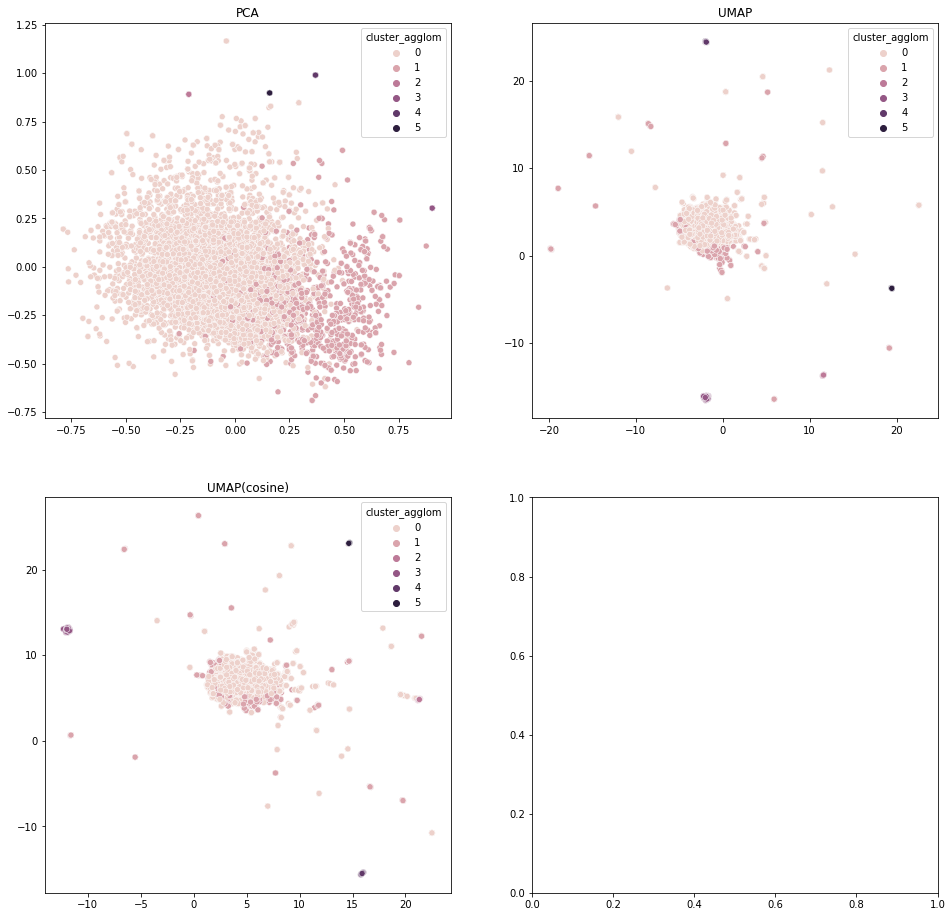

In [41]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=elon_df['cluster_agglom']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=elon_df['cluster_agglom']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=elon_df['cluster_agglom']);

In [42]:
elon_df.groupby('cluster_agglom')['cluster_agglom'].count()

cluster_agglom
0    6973
1    1202
2      87
3     221
4      91
5      71
Name: cluster_agglom, dtype: int64

In [43]:
for cluster in set(elon_df['cluster_agglom']):
    print(
        f'Cluster {cluster:3}. {len(elon_df.query(f"cluster_agglom == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(elon_df.query(f'cluster_agglom == {cluster}').text, n=3)
    )

Cluster   0.  6973 tweets total. Top-3 words: [('tesla', 637), ('great', 313), ('good', 285)]
Cluster   1.  1202 tweets total. Top-3 words: [('haha', 83), ('ok', 55), ('yeah', 47)]
Cluster   2.    87 tweets total. Top-3 words: [('true', 87)]
Cluster   3.   221 tweets total. Top-3 words: [('yes', 221)]
Cluster   4.    91 tweets total. Top-3 words: [('exactly', 91)]
Cluster   5.    71 tweets total. Top-3 words: [('sure', 71)]


In [44]:
cluster = 5

print('Entries:', len(elon_df.query(f'cluster_agglom == {cluster}')))
print(print_top_n_words(elon_df.query(f'cluster_agglom == {cluster}').text))
elon_df.query(f'cluster_agglom == {cluster}').head(10)#.text.apply(text_preprocessor)

Entries: 71
[('sure', 71)]


,text,date,datetime,cluster,cluster_dbscan,cluster_agglom
id,,,,,,
1208518677458341888,@lukemiler @Jon_Favreau For sure,2019-12-21,2019-12-21 22:44:40,3,0,5
1208154686148108288,@Erdayastronaut @NASA @BoeingSpace For sure!🤞,2019-12-20,2019-12-20 22:38:18,3,0,5
1205029016761094150,@andrewMcarney @Tesla Sure,2019-12-12,2019-12-12 07:38:00,3,0,5
1203114454881189888,@vicentes @neiltyson For sure,2019-12-07,2019-12-07 00:50:13,3,0,5
1198093416359325697,@SuperSaf @Tesla Sure,2019-11-23,2019-11-23 04:18:24,3,0,5
1188645875750322176,@SnazzyQ @Tesla Sure,2019-10-28,2019-10-28 02:37:15,3,0,5
1187363892009168896,@KlausLovgreen Sure,2019-10-24,2019-10-24 13:43:06,3,0,5
1180877420821237760,@teslaownersSV Sure,2019-10-06,2019-10-06 16:08:11,3,0,5
1171499981821243399,@kimpaquette @Tesla For sure!,2019-09-10,2019-09-10 19:05:35,3,0,5
